In [1]:
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import os, random, sys
from create_datagenerators import create_data_generators
import json
from sklearn.metrics import confusion_matrix
from data_preprocessing import resize_white, resize_black
from tensorflow.keras.utils import plot_model
from collections import Counter
import pandas as pd
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
# # model trained on original imgs
# RESULTS_FOLDER = "../saved_models/BEST_OF_THE_BEST/best_orginal_img_alllayers_v3/20190701_1148"
# resize = False

# model trained on resized imgs
RESULTS_FOLDER = "../saved_models/BEST_OF_THE_BEST/all_layers_trained_lhcbgpu_inceptionv3_RESIZEDIMGS/20190626_0944"
resize = True

# model trained on b&w imgs
# RESULTS_FOLDER = "../saved_models/july_tg/20190731_1323"
# resize = False


HYPERPARAMS_FILE =  RESULTS_FOLDER+ '/hyperparams.json'

with open(HYPERPARAMS_FILE, "r") as read_file:
    data = json.load(read_file)

HYPERPARAMS = data['hyperparameters'][0]
BATCHSIZE = HYPERPARAMS['BATCHSIZE']

#20190612_1048
if (os.getcwd() == '/home/kalkami/translearn'):
    #lhcpgpu1
    TRAIN_DIR = '/data/IntelliGate/kalkami/DATASETS/carsStanford_all/train'
    TEST_DIR = '/data/IntelliGate/kalkami/DATASETS/carsStanford_all/test'
    TRAIN_DIR_TST = TRAIN_DIR
    TEST_DIR_TST = TEST_DIR
    VALID_DIR_TST = TEST_DIR
else:
    #local
    TRAIN_DIR = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/train'
    TEST_DIR = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test'
    TRAIN_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/train'
    TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all_bw/test'
    TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test'
    VALID_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/CARS_GOOGLE_IMG/downloads'



In [3]:
def load_image(img_path, input_shape, resize = False):
    if resize:
        img, pth = resize_black(input_shape[1], img_path, print_oldsize=False)
    else:
        img = image.load_img(img_path, target_size=input_shape)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    return img_tensor


        
def generate_data_generators(input_shape):
    generator_train, generator_test = create_data_generators(input_shape, BATCHSIZE, 
                                                                TRAIN_DIR, TEST_DIR, 
                                                                save_augumented=None, 
                                                                plot_imgs = False)
    return generator_train, generator_test
        
        
def load_model(results_folder):
    # load json and create model
    json_file = open(results_folder + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(results_folder + "/weights.best.hdf5")
    input_shape = loaded_model.layers[0].output_shape[1:3]
    print("Loaded model from disk")
    return loaded_model, input_shape
       
    
        
def decode_predictions(preds, class_names, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

def predict(img_path, model, input_shape, class_names, correct_class, resize=False, show_imgs=True, top=5):
    img_array = load_image(img_path, input_shape, resize = resize)
    preds = model.predict(img_array)
    predictions = decode_predictions(preds, class_names, top=top)
    top1_pred = predictions[0][0]
    #print(predictions)
    #print(correct_class)
    if show_imgs:
        img_org = image.load_img(img_path)
        fig, axs = plt.subplots(1,2)
        axs[0].set_title(correct_class)
        axs[0].imshow(img_org)
        axs[1].set_title(str(top1_pred))
        axs[1].imshow(img_array[0])
        plt.show()
    return predictions
      
        
        
def return_class_names_list(results_folder):
    class_names = []
    # open file and read the content in a list
    with open(results_folder+'/class_names.txt', 'r') as filehandle:  
        for line in filehandle:
            current_line = line[:-1]
            class_names.append(current_line)
    return class_names
        
def perform_pred(loaded_model, resize=False, car_class=None, img_pth=None, show_imgs=True):
    test_dir = TEST_DIR_TST
    results_folder = RESULTS_FOLDER
    
    if os.path.exists(results_folder+'/class_names.txt'):
        class_names = return_class_names_list(results_folder)

    else:
        generator_train, generator_test = generate_data_generators(results_folder, input_shape)
        class_names = list(generator_train.class_indices.keys())
        print(class_names)
        with open(results_folder+'/class_names.txt', 'w') as filehandle:  
            for listitem in class_names:
                filehandle.write('%s\n' % listitem)
                
    if car_class is None:
        car_class = random.choice(class_names)
    
    if img_pth is None: 
        # randomly select an image from defined class     
        test_dir_full = test_dir + '/' + car_class
        test_img = test_dir_full + '/' + random.choice(os.listdir(test_dir_full))
    else:
        test_img = img_pth
        
    
    input_shape = loaded_model.layers[0].output_shape[1:3]
    
          
    predictions = predict(test_img, loaded_model, input_shape, class_names, car_class, resize=resize, show_imgs=show_imgs)
    print(predictions)

In [4]:
loaded_model, input_shape=load_model(RESULTS_FOLDER)
generator_train, generator_test = generate_data_generators(input_shape)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
Found 8103 images belonging to 195 classes.
Found 8000 images belonging to 195 classes.


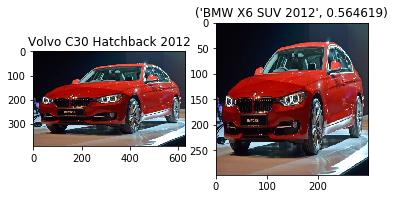

[[('BMW X6 SUV 2012', 0.564619), ('BMW 3 Series Sedan 2012', 0.095533215), ('Volvo C30 Hatchback 2012', 0.064190291), ('Dodge Charger Sedan 2012', 0.06199979), ('Audi TTS Coupe 2012', 0.021349728)]]


In [5]:
perform_pred(loaded_model, resize=False, car_class=None, img_pth=TEST_DIR_TST+'/'+'/BMW 3 Series Sedan 2012'+'/01631.jpg', show_imgs=True)

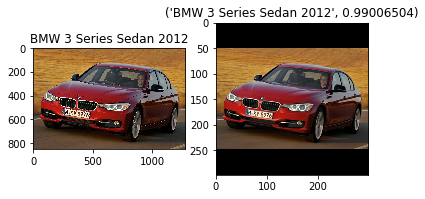

[[('BMW 3 Series Sedan 2012', 0.99006504), ('BMW 3 Series Wagon 2012', 0.0085977986), ('BMW X3 SUV 2012', 0.00068987446), ('Mitsubishi Lancer Sedan 2012', 0.00014553414), ('BMW 1 Series Coupe 2012', 0.00010193948)]]


In [15]:
perform_pred(loaded_model, resize=True, car_class='BMW 3 Series Sedan 2012', img_pth=None, show_imgs=True)

In [ ]:
#img_pth = '../test_imgs/mercs.jpg'
#img_pth=TEST_DIR_TST+'/'+'/BMW 3 Series Sedan 2012'+'/01631.jpg')
#def perform_pred(loaded_model, resize=False, car_class=None, img_pth=None, show_imgs=True)
'/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test/MINI Cooper Roadster Convertible 2012/00725.jpg'